In [1]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import time
np.random.seed(42)

# Create the election

Let's generate data for our election. In this notebook, an election is $1000$ voters, $10\%$ of them vote for $1$, $10\%$ of them vote for $2$, and the others are delegating voters or abstaining voters.

Then I randomly add $3200$ edges in the delegating graph, which gives around $4$ delegatees per delegating voter in average.

In [37]:
def create_election(n=1000, p=0.8, n_delegatees=4):
    e = rd.Election()
    for i in range(n):
        x = np.random.choice([0,1,2],p=[p,(1-p)/2,(1-p)/2])
        if x == 0:
            v = rd.Voter()
        else:
            v = rd.Voter(vote=x)
        e.add_voter(v)

    L = e.list_voters
    delegatees = [[] for i in range(n)]
    n_edges = 0
    while n_edges < n*p*n_delegatees:
        r_1 = np.random.randint(n)
        r_2 = np.random.randint(n)
        if r_1 == r_2 or L[r_2] in delegatees[r_1] or L[r_1].vote is not None:
            continue
        else:
            delegatees[r_1].append(L[r_2])
            n_edges += 1

    for voter in L:
        voter.delegate(delegatees[voter.id])
    
    return e 

e = create_election(20)

In [39]:
def create_election_popularity(n=1000, p=0.8, n_delegatees=4, popularity_factor=1):
    e = rd.Election()
    for i in range(n):
        x = np.random.choice([0,1,2],p=[p,(1-p)/2,(1-p)/2])
        if x == 0:
            v = rd.Voter()
        else:
            v = rd.Voter(vote=x)
        e.add_voter(v)

    L = e.list_voters
    delegatees = [[] for i in range(n)]
    n_edges = 0
    proba = np.ones(n)
    while n_edges < n*p*n_delegatees:
        r_1 = np.random.randint(n)
        if L[r_1].vote is not None:
            continue
        
        proba_curr = np.copy(proba)
        proba_curr[r_1] = 0
        proba_curr **= popularity_factor
        proba_curr /= proba_curr.sum()
        
        r_2 = np.random.choice(n, p=proba_curr)
        if r_1 == r_2 or L[r_2] in delegatees[r_1]:
            continue
        else:
            delegatees[r_1].append(L[r_2])
            proba[r_2] += 1
            n_edges += 1

    for voter in L:
        voter.delegate(delegatees[voter.id])
    
    return e 

e = create_election_popularity(1000, popularity_factor=1)

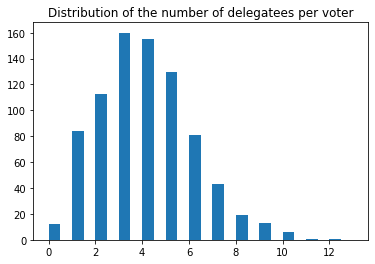

In [29]:
edges_array = []
for voter in e.list_voters:
    if voter.vote is None:
        edges_array.append(len(voter.delegatees))

plt.hist(edges_array, bins=max(edges_array), width=0.5)
plt.title("Distribution of the number of delegatees per voter")
plt.show()

# Using different rules

This is a utility function to print the results

In [30]:
def print_results(e):
    print("Winner is %i"%e.winner)
    print("Results : ",e.results)
    print("Maximum rank is %i"%e.max_rank)
    print("Maximum length is %i"%e.max_length)
    print("Maximum guru power is %i"%e.max_power)
    print("Maximum sum of rank is %i"%e.max_sum)
    print("Sum of rank is %i (only for confluent rules)"%e.sum_rank)
    print("Unpopularity is %i (only for confluent rules)"%e.unpopularity)

## BFD

$ s_1 > s_2$ if $len(s_1) > len(s_2)$. In case of tie, use lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | + |

In [31]:
e.attribute_gurus(rd.rules.naive_BFD)
print_results(e)

Winner is 2
Results :  [[424, 1], [564, 2]]
Maximum rank is 8
Maximum length is 4
Maximum guru power is 38
Maximum sum of rank is 12
Sum of rank is 1537 (only for confluent rules)
Unpopularity is 391 (only for confluent rules)


## DFD

Lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  -  |
| Copy Robust| +  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | - |
| Weakly Lex. | + |
| Strongly Lex. | + |

In [32]:
e.attribute_gurus(rd.rules.naive_DFD)
print_results(e)

Winner is 2
Results :  [[310, 1], [678, 2]]
Maximum rank is 2
Maximum length is 16
Maximum guru power is 207
Maximum sum of rank is 16
Sum of rank is 811 (only for confluent rules)
Unpopularity is 0 (only for confluent rules)


Note that sum of rank here cannot be used since DFD is not a confluent rule. Moreover, the sum of ranks for DFD is lower bound for the best sum of rank among confluent rules.

## Diffusion

ML-Algo.

| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | + |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [33]:
e.attribute_gurus(rd.rules.diffusion)
print_results(e)

Winner is 2
Results :  [[310, 1], [678, 2]]
Maximum rank is 2
Maximum length is 16
Maximum guru power is 206
Maximum sum of rank is 17
Sum of rank is 820 (only for confluent rules)
Unpopularity is 9 (only for confluent rules)


## MinSum

$s_1 > s_2$ if $sum(s_1) < sum(s_2)$. Tie breaking with lexicographical order.

| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | - |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [34]:
e.attribute_gurus(rd.rules.minsum)
print_results(e)

Winner is 2
Results :  [[410, 1], [578, 2]]
Maximum rank is 4
Maximum length is 6
Maximum guru power is 47
Maximum sum of rank is 7
Sum of rank is 1054 (only for confluent rules)
Unpopularity is 205 (only for confluent rules)


## LexRank

Define the function : $f(s) = reverse(sorted(s))$. For instance, $f((2,1,3,3,1,2,4)) = (4,3,3,2,2,1)$.

Then, $s_1 > s_2$ if $f(s_1) >_{lex} f(s_2)$. Tie breaking with lexicographical order.


| Property | OK ?|
|----------|-----|
| Confluent|  +  |
| Copy Robust| -  |
| Path consistent | + |
| Rank-aware    | + |
| Length-aware | + |
| Weakly Lex. | + |
| Strongly Lex. | - |

In [35]:
e.attribute_gurus(rd.rules.lexrank)
print_results(e)

Winner is 2
Results :  [[313, 1], [675, 2]]
Maximum rank is 2
Maximum length is 16
Maximum guru power is 204
Maximum sum of rank is 16
Sum of rank is 816 (only for confluent rules)
Unpopularity is 5 (only for confluent rules)


# Averaging

We can't say a lot with one experiment, let's run a $1000$ and see what happens.

In [40]:
rules = [rd.rules.naive_BFD, rd.rules.naive_DFD, 
         rd.rules.diffusion, rd.rules.minsum, rd.rules.lexrank, rd.rules.minSumRank]
n_rules = len(rules)
tab_results = np.zeros((6, n_rules))
n_iter = 1000
n_voter = 1000

for _ in tqdm(range(n_iter)):
    e = create_election_popularity(n_voter)
        
    for i, rule in enumerate(rules):
        e.attribute_gurus(rule)
        tab_results[0, i] += e.max_rank
        tab_results[1, i] += e.max_length
        tab_results[2, i] += e.max_power
        tab_results[3, i] += e.max_sum
        tab_results[4, i] += e.sum_rank
        tab_results[5, i] += e.unpopularity
        if i == 4 and e.unpopularity < 0:
            raise ValeError()
    
tab_results /= n_iter
    

100%|██████████| 1000/1000 [39:29<00:00,  2.37s/it]


In [41]:
df = pd.DataFrame(data=tab_results.T, 
                  index=["BFD", "DFD","Diffusion", "MinSum", "LexRank","MinRankSum"], 
                  columns=["Max Rank", "Max Length", "Max Power", "Max Sum", "Sum of Rank", "Unpopularity"])

df

,Max Rank,Max Length,Max Power,Max Sum,Sum of Rank,Unpopularity
BFD,8.776,4.094,30.302,10.771,1555.008,389.130
DFD,2.216,19.876,117.002,20.540,795.744,-0.760
Diffusion,2.129,17.604,111.866,17.944,844.834,48.324
MinSum,4.213,5.743,39.333,6.463,1065.989,216.945
LexRank,2.129,17.479,106.443,17.580,821.718,25.212
MinRankSum,2.137,19.257,120.466,19.778,796.505,0.001


# Changing parameters

We cannot conclude with fixed parameters, let's tune them a little bit.

In [48]:
rules = [rd.rules.naive_BFD, rd.rules.naive_DFD, 
         rd.rules.diffusion, rd.rules.minsum, rd.rules.lexrank, rd.rules.minSumRank]
n_rules = len(rules)

def experiment(n_iter=100, n=1000,p=0.8,n_delegatees=4,popularity=1):
    tab_results = np.zeros((5, n_rules))
    for _ in range(n_iter):
        e = create_election_popularity(n, p, n_delegatees,popularity)

        for i, rule in enumerate(rules):
            e.attribute_gurus(rule)
            tab_results[0, i] += e.max_rank
            tab_results[1, i] += e.max_length
            tab_results[2, i] += e.max_power
            tab_results[3, i] += e.max_sum
            tab_results[4, i] += e.sum_rank

    tab_results /= n_iter
    return tab_results

In [49]:
def print_everything(evolution, parameter_name, parameter_tab):
    
    measures_list = ["Max rank", "Max length", "Max power", "Max sum", "Sum of rank"]
    rules_name = ["BFD", "DFD","Diffusion", "MinSum", "LexRank", "MinSumRank"]
    
    for i, name in enumerate(measures_list):
        plt.figure(figsize=(20,4))
        for k in range(n_rules):
            plt.plot(parameter_tab, [ev[i, k] for ev in evolution], 'o-', label=rules_name[k])
        plt.legend()
        plt.title(name)
        plt.grid()
        plt.show()
    

## Evolution with the number of nodes

The number of voters vary from $50$ to $500$, the probabilities to be a delegating voter is $80\%$ and the average number of delegatees by delegating voter is $4$.

In [50]:
tab_n = np.linspace(50,500,20)
evolution = []
for n in tqdm(tab_n):
    evolution.append(experiment(n=int(n)))

100%|██████████| 20/20 [06:41<00:00, 20.08s/it]


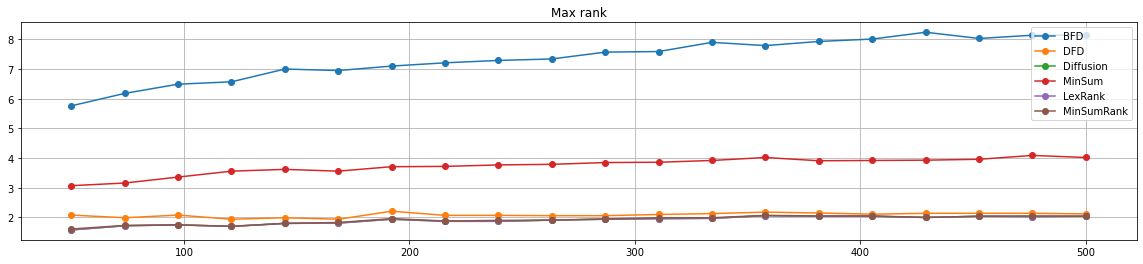

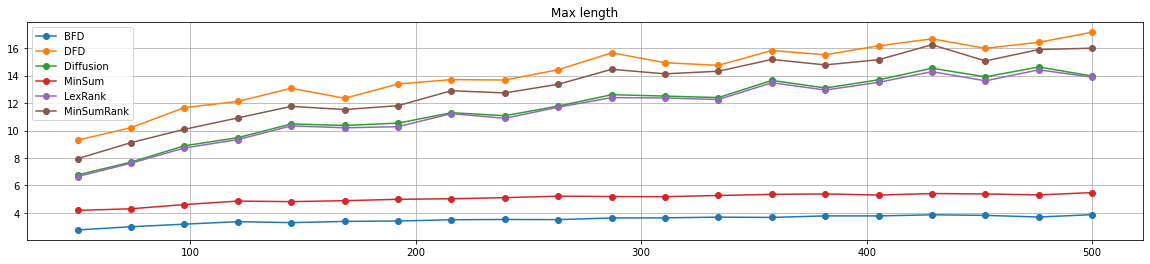

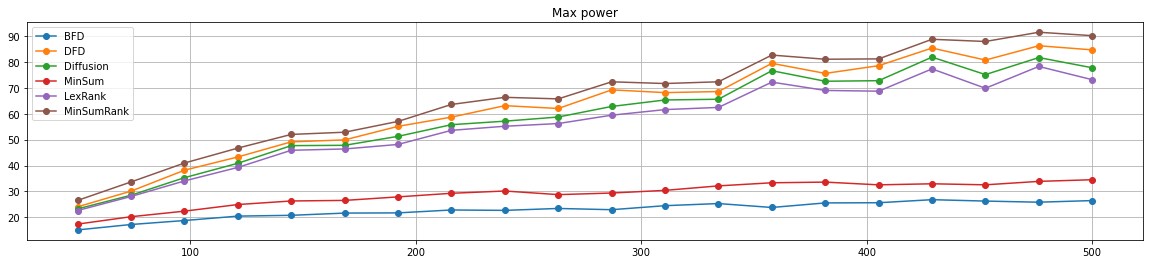

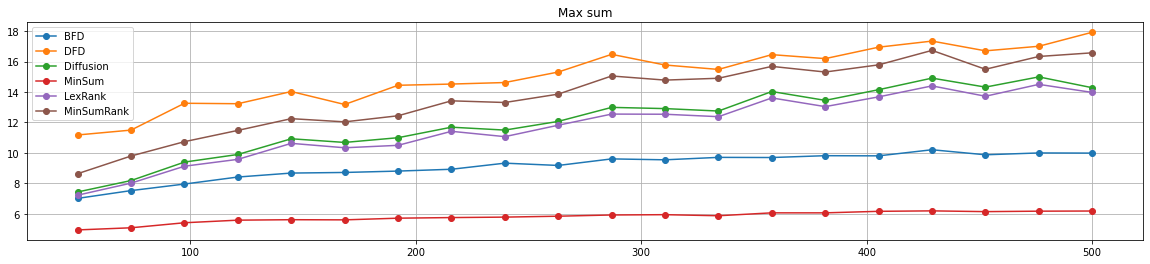

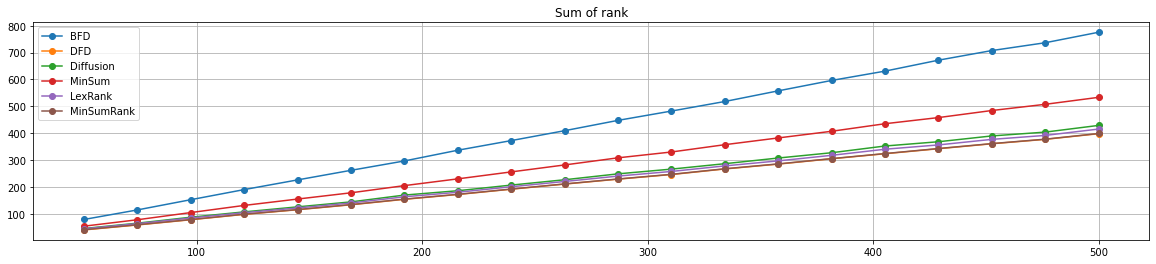

In [51]:
print_everything(evolution, "n", tab_n)

## Evolution with the proportion of delegating voters

The number of voter is $1000$, the proportion of delegating voter vary from $20\%$ to $90\%$ and the average number of delegatees per delegating voters is $4$.

In [52]:
tab_p = np.linspace(0.2,0.9,15)
evolution = []
for p in tqdm(tab_p):
    evolution.append(experiment(p=p))

100%|██████████| 15/15 [13:52<00:00, 55.52s/it]


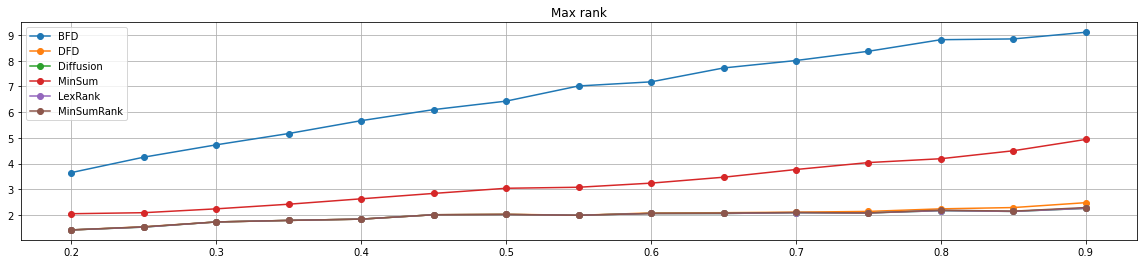

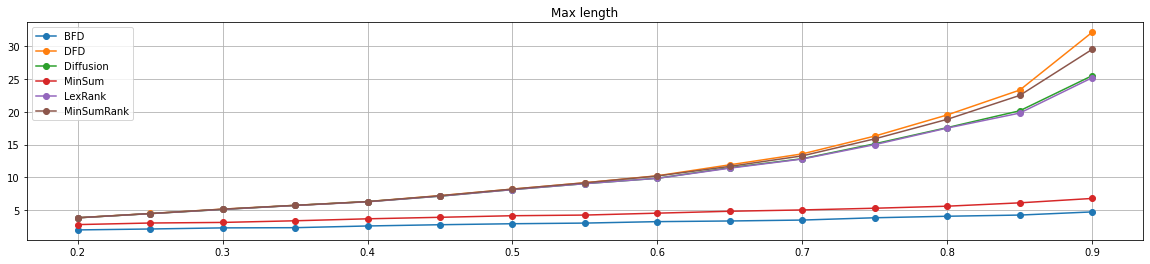

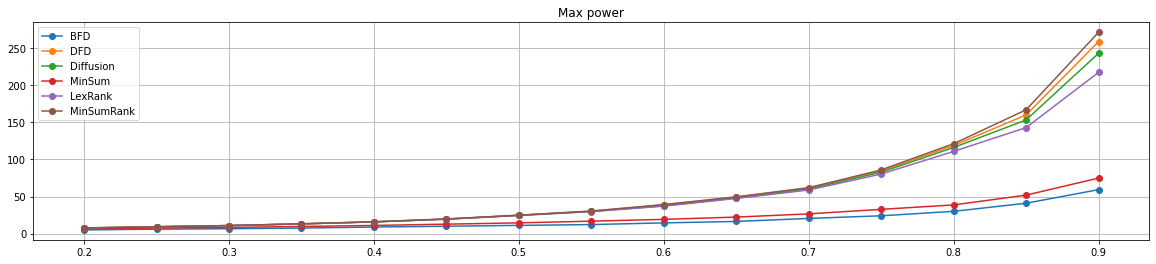

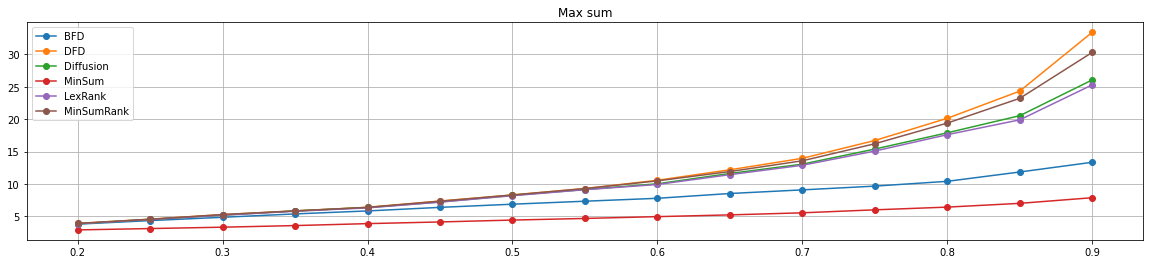

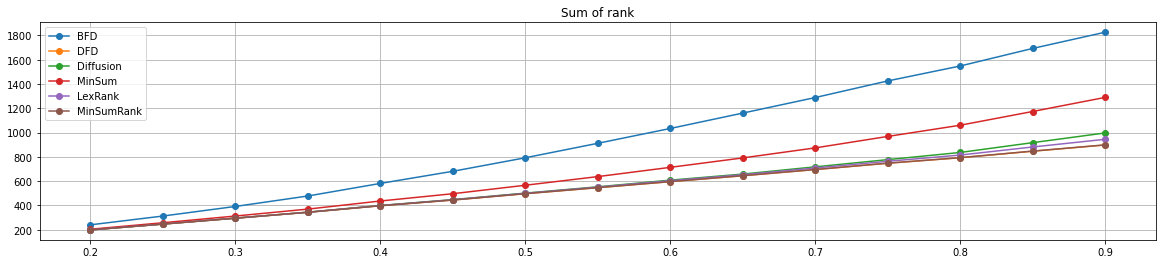

In [53]:
print_everything(evolution, "p", tab_p)

## Evolution with the average number of delegatees

The number of voters is $1000$, the proportion of delegating voters is $80\%$ and the average number of delegatees per delegating voters vary from $1$ to $8$.

In [54]:
tab_edges = np.arange(1,9)
evolution = []
for n_edges in tqdm(tab_edges):
    evolution.append(experiment(n_delegatees=n_edges))

100%|██████████| 8/8 [13:23<00:00, 100.38s/it]


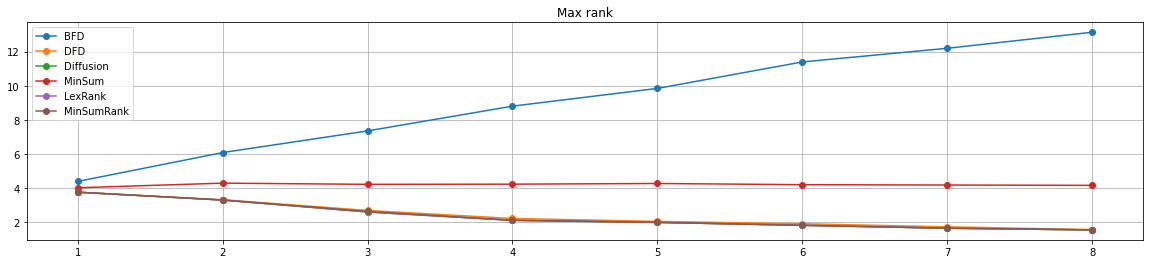

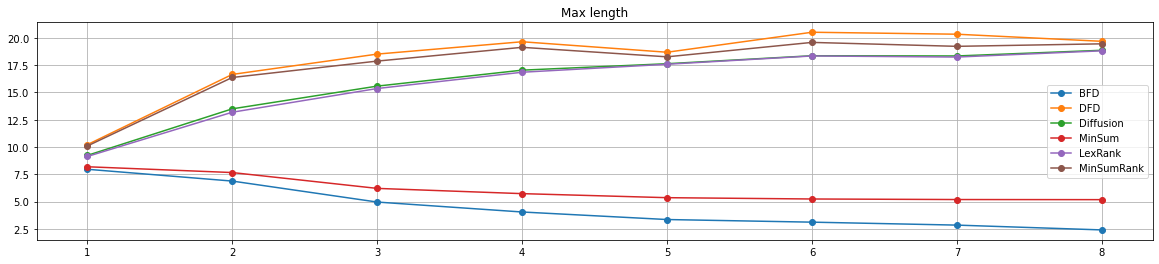

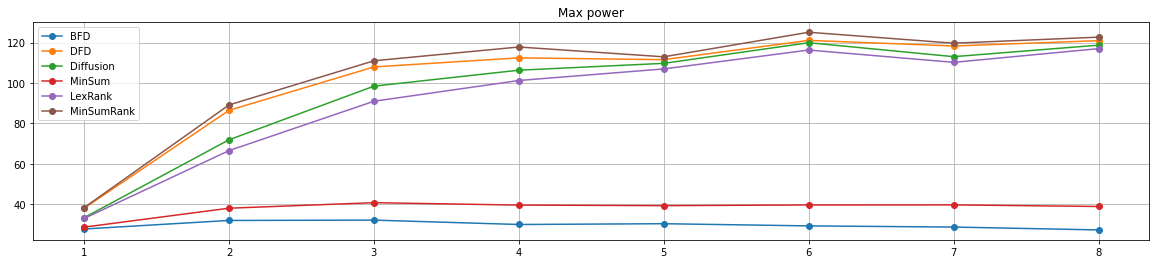

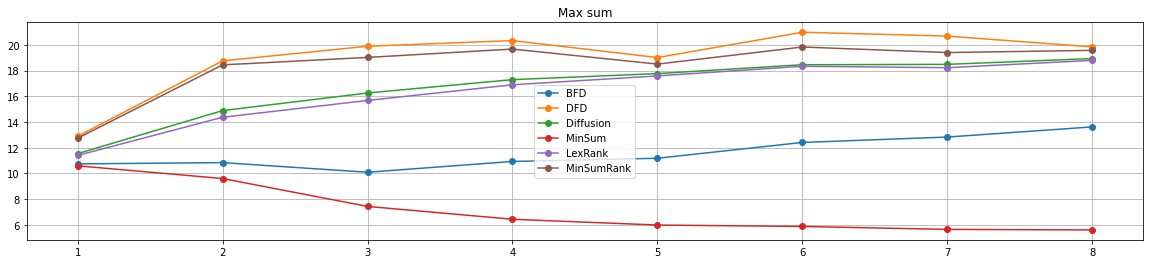

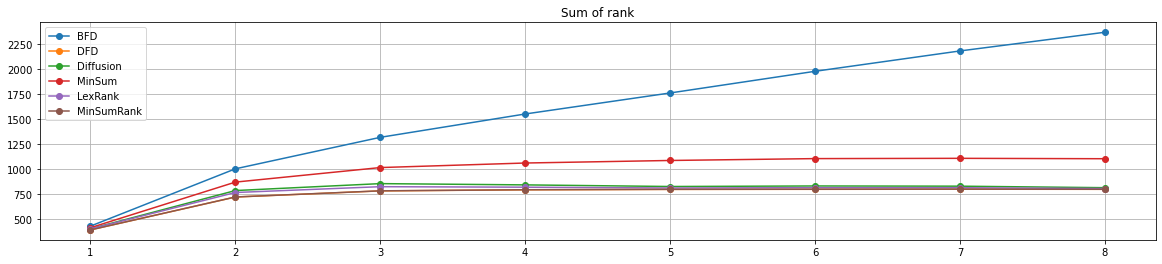

In [55]:
print_everything(evolution, "number of delegatees", tab_edges)

## Evolution with popularity facotr

In [56]:
tab_pop = np.linspace(0,1,11)
evolution = []
for pop in tqdm(tab_pop):
    evolution.append(experiment(popularity=pop))

100%|██████████| 11/11 [14:27<00:00, 78.90s/it]


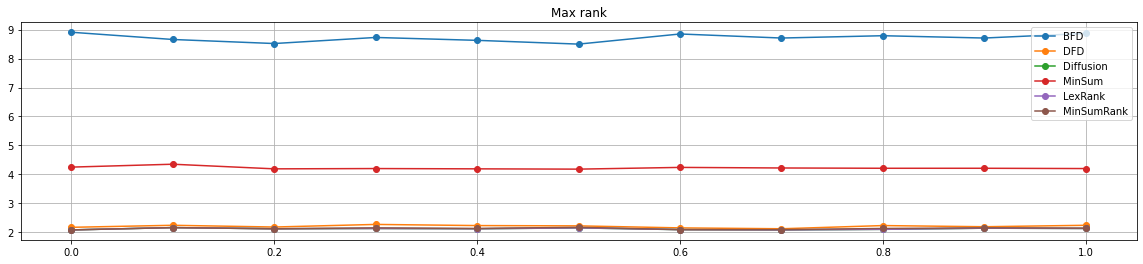

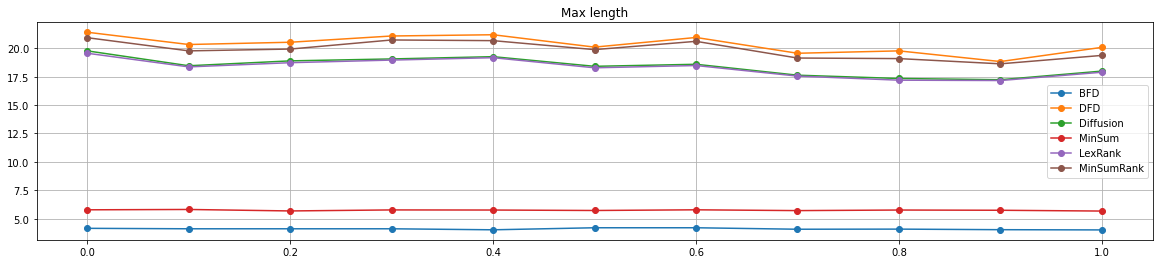

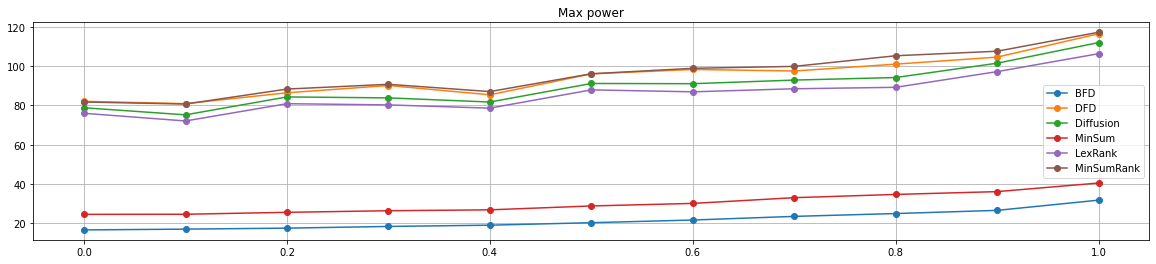

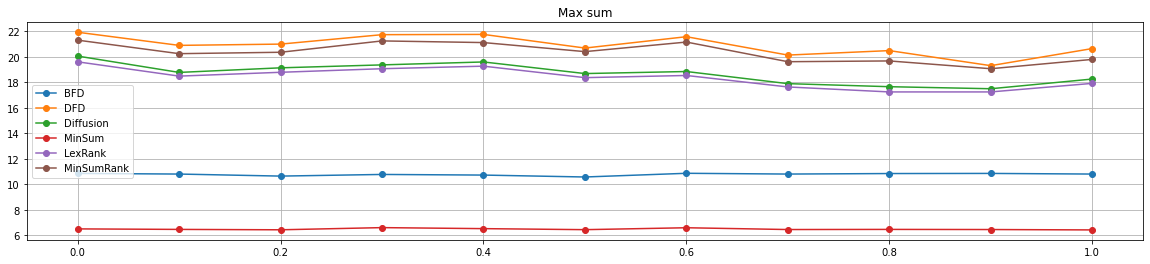

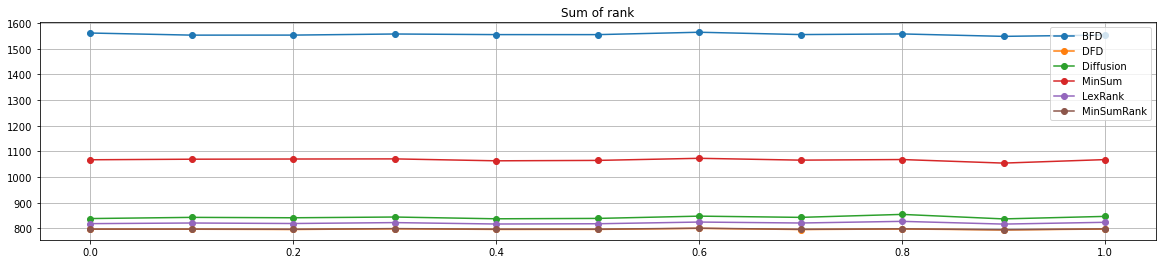

In [57]:
print_everything(evolution, "Popularity factor", tab_pop)

# Comment

| Property  | BFD    | DFD   | Diffusion   | MaxSum   | LexRank    |
|-----------|--------|-------|-------------|----------|------------|
| Max Rank  |  --    |  +    |   ++        | -        |   ++       |
| Max Length|  ++    |  --   |    --       |     +    |  --        |
| Max Power |   ++   |  --   | --          | +        |  --        |
| Max Sum   |  +     | --    |   --        | ++       |  --        |
| Sum Rank  |  ---   |  0   |    +        | -        | ++         | 
| Explainability | +  | +   | +            |    +     | +-        |